<a href="https://colab.research.google.com/github/M-saber31/Tammathon_Code/blob/main/Compliance_check.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ICAO Photo Standards Compliance Classifier

A machine learning model to determine whether passport photos meet ICAO (International Civil Aviation Organization) standards. The model classifies images as compliant (1) or non-compliant (0) based on factors like head positioning, background uniformity, lighting, and facial visibility.

In [ ]:
import kagglehub
kagglehub.login()

Kaggle credentials set.
Kaggle credentials successfully validated.


In [ ]:
tammathon_task_2_path = kagglehub.competition_download('tammathon-task-2')

print(f"Data saved to: {tammathon_task_2_path}")

print('Data source import complete.')

100%|██████████| 1.79G/1.79G [00:12<00:00, 156MB/s]

Extracting files...


Data saved to: /root/.cache/kagglehub/competitions/tammathon-task-2
Data source import complete.


In [ ]:
# Install required packages
!pip install -q timm albumentations==1.3.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.7/125.7 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 114.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 97.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 60.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 44.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 104.8 MB/s eta 0:00:00


In [ ]:
# Import libraries
import os
import numpy as np
import pandas as pd
import time
import gc
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import timm
import albumentations as A
from albumentations.pytorch import ToTensorV2

from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, classification_report

# Enable mixed precision training for faster computations on A100
from torch.amp import autocast, GradScaler
scaler = GradScaler()

# Set random seeds for reproducibility
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} for training")
print(f"CUDA version: {torch.version.cuda}")
print(f"Torch version: {torch.__version__}")

Using cuda for training
CUDA version: 12.4
Torch version: 2.6.0+cu124


<ipython-input-5-143b2f67838e>:24: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


In [ ]:
# For A100 GPU - verify compute capability
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
    print(f"Compute capability: {torch.cuda.get_device_capability(0)}")

GPU: NVIDIA A100-SXM4-40GB
Memory: 42.47 GB
Compute capability: (8, 0)


## Configuration

In [ ]:
# Define paths 
BASE_DIR = '/root/.cache/kagglehub/competitions/tammathon-task-2'
OUTPUT_DIR = '.'

# File paths
TRAIN_CSV = os.path.join(BASE_DIR, 'train.csv')
VAL_CSV = os.path.join(BASE_DIR, 'val.csv')
TEST_CSV = os.path.join(BASE_DIR, 'test.csv')
OUTPUT_FILE = os.path.join(OUTPUT_DIR, 'submission.csv')

# Model parameters
MIXED_PRECISION = True  # Use mixed precision for A100 GPU
IMG_SIZE = 384          # Larger image size for better detail
BATCH_SIZE = 64         # Larger batch size for A100
NUM_EPOCHS = 30          # Fewer epochs to get results quickly
LEARNING_RATE = 1e-4    # Lower learning rate for stability
WEIGHT_DECAY = 1e-5     # L2 regularization
MODEL_NAME = 'efficientnet_b4'  # Better model - more accurate but still fast
NUM_WORKERS = 4         # More workers for data loading
USE_AMP = True          # Automatic mixed precision (for A100)

# Print configuration
print(f"Model: {MODEL_NAME}")
print(f"Image size: {IMG_SIZE}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Learning rate: {LEARNING_RATE}")
print(f"Using mixed precision: {MIXED_PRECISION}")

## Data Loading

In [ ]:
# Load CSV files
try:
    train_df = pd.read_csv(TRAIN_CSV)
    val_df = pd.read_csv(VAL_CSV)
    test_df = pd.read_csv(TEST_CSV)

    print(f"Training set: {len(train_df)} images")
    print(f"Validation set: {len(val_df)} images")
    print(f"Test set: {len(test_df)} images")

    # Check class distribution in training set
    if 'label' in train_df.columns:
        train_class_counts = train_df['label'].value_counts()
        print(f"\nTraining class distribution: \n{train_class_counts}")
        n_compliant = train_class_counts.get(1, 0)
        n_non_compliant = train_class_counts.get(0, 0)
        print(f"Ratio (non-compliant:compliant): {n_non_compliant/n_compliant:.2f}")

    # Check class distribution in validation set
    if 'label' in val_df.columns:
        val_class_counts = val_df['label'].value_counts()
        print(f"\nValidation class distribution: \n{val_class_counts}")

    # Sample a few rows from each set
    print("\nTraining sample:")
    print(train_df.head(3))
    print("\nValidation sample:")
    print(val_df.head(3))
    print("\nTest sample:")
    print(test_df.head(3))

    # Calculate class weights for handling imbalance
    if 'label' in train_df.columns:
        total = len(train_df)
        n_compliant = train_class_counts.get(1, 0)
        n_non_compliant = train_class_counts.get(0, 0)

        # Compute weights inversely proportional to class frequencies
        weight_compliant = total / (2 * n_compliant)
        weight_non_compliant = total / (2 * n_non_compliant)
        class_weights = torch.FloatTensor([weight_non_compliant, weight_compliant]).to(device)
        print(f"\nClass weights: {class_weights}")
except Exception as e:
    print(f"Error loading data: {e}")

Training set: 3978 images
Validation set: 853 images
Test set: 853 images

Training class distribution: 
label
0    3800
1     178
Name: count, dtype: int64
Ratio (non-compliant:compliant): 21.35

Validation class distribution: 
label
0    815
1     38
Name: count, dtype: int64

Training sample:
                                         path  label
0  train/3976d5e7607d4b6bb360f151b18dc59c.png      0
1  train/d1bddb2168d84136b3b5d99a0a1fde9e.png      0
2  train/1d79ff281cf54fa2a2376632318b09e4.png      0

Validation sample:
                                       path  label
0  val/07a6ccdc0c0b45cfb26fed1e13cd7747.png      0
1  val/cd5d23347f2c4424a9b73bb43edd9d97.png      0
2  val/8bededc2d51a4341b357c86387e776a6.png      0

Test sample:
                                        path
0  test/7ec8b90644fa446ba599b4647d373e5a.png
1  test/0ebd68bd949946d2a1980ba492019fde.png
2  test/64e3460b8fb943f4afff5d5446d81cfb.png

Class weights: tensor([ 0.5234, 11.1742], device='cuda:0')


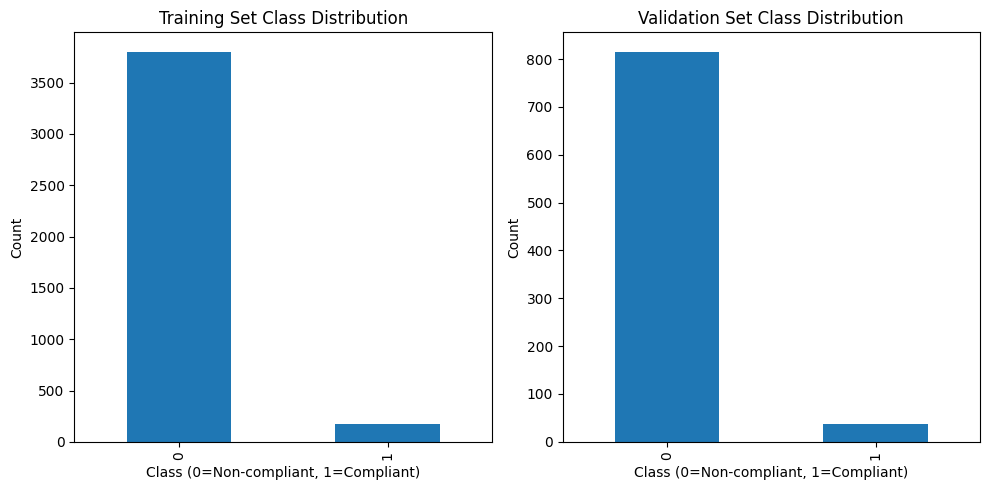

In [ ]:
# Visualize class distribution
if 'label' in train_df.columns:
    plt.figure(figsize=(10, 5))
    ax1 = plt.subplot(1, 2, 1)
    train_df['label'].value_counts().plot(kind='bar', ax=ax1)
    ax1.set_title('Training Set Class Distribution')
    ax1.set_xlabel('Class (0=Non-compliant, 1=Compliant)')
    ax1.set_ylabel('Count')

    ax2 = plt.subplot(1, 2, 2)
    val_df['label'].value_counts().plot(kind='bar', ax=ax2)
    ax2.set_title('Validation Set Class Distribution')
    ax2.set_xlabel('Class (0=Non-compliant, 1=Compliant)')
    ax2.set_ylabel('Count')

    plt.tight_layout()
    plt.show()

Sample training images:


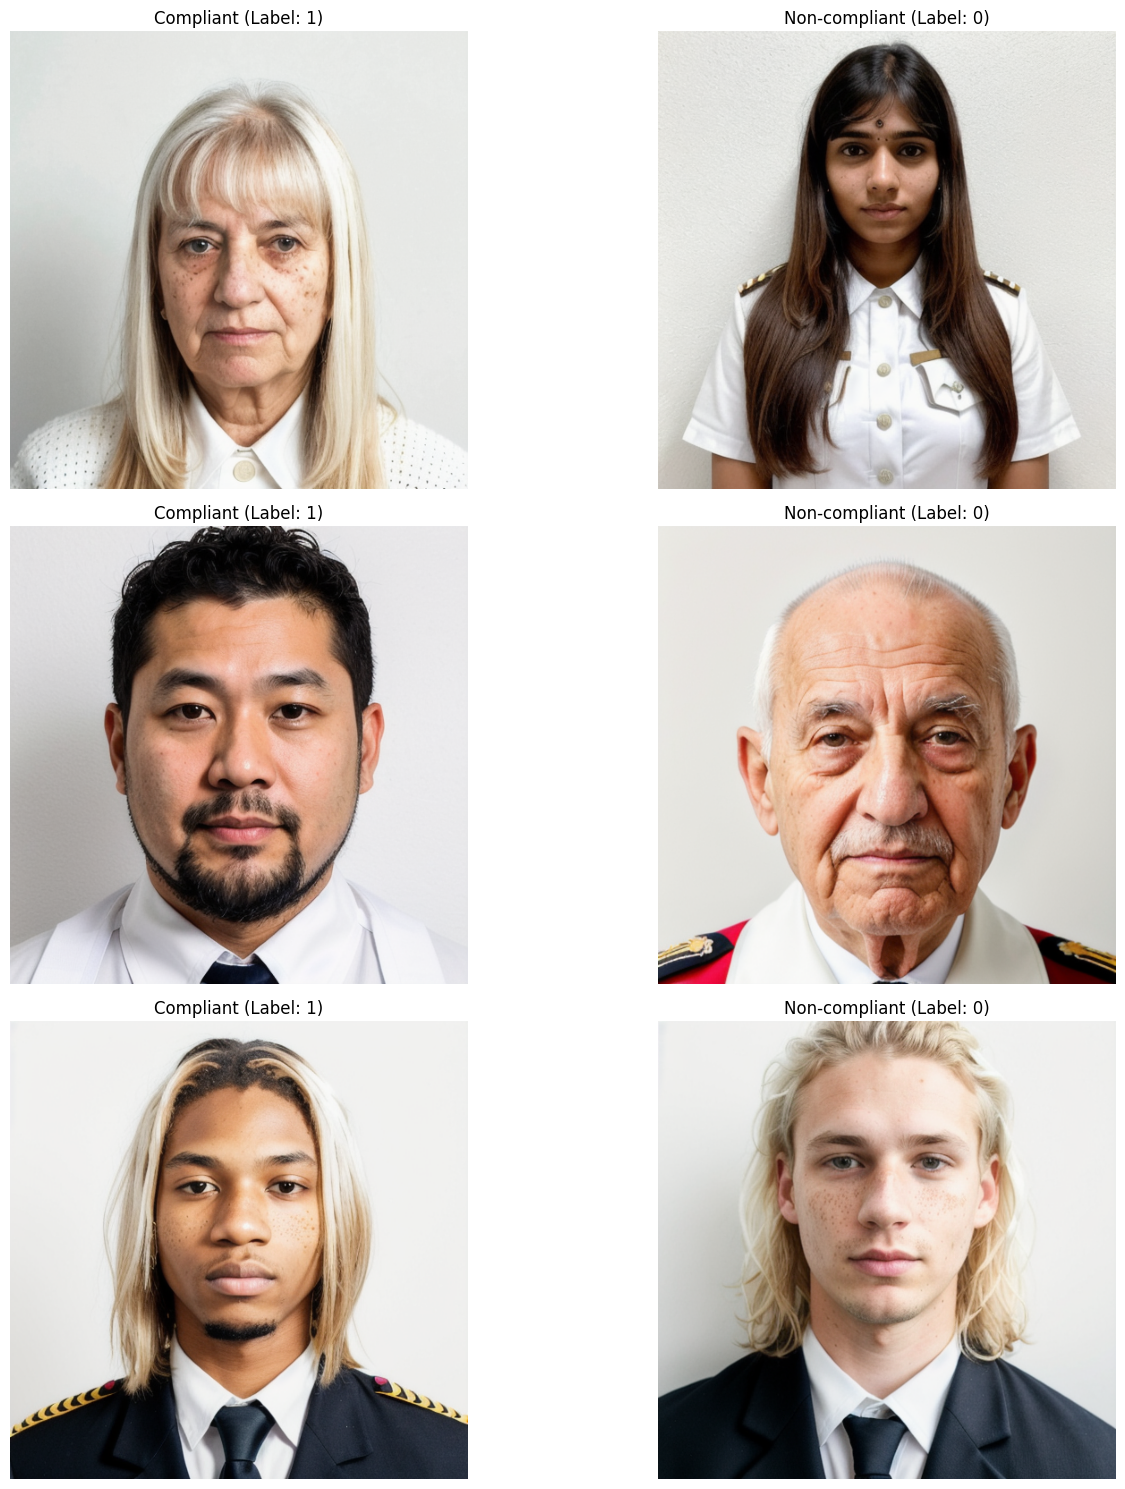

Sample test images:


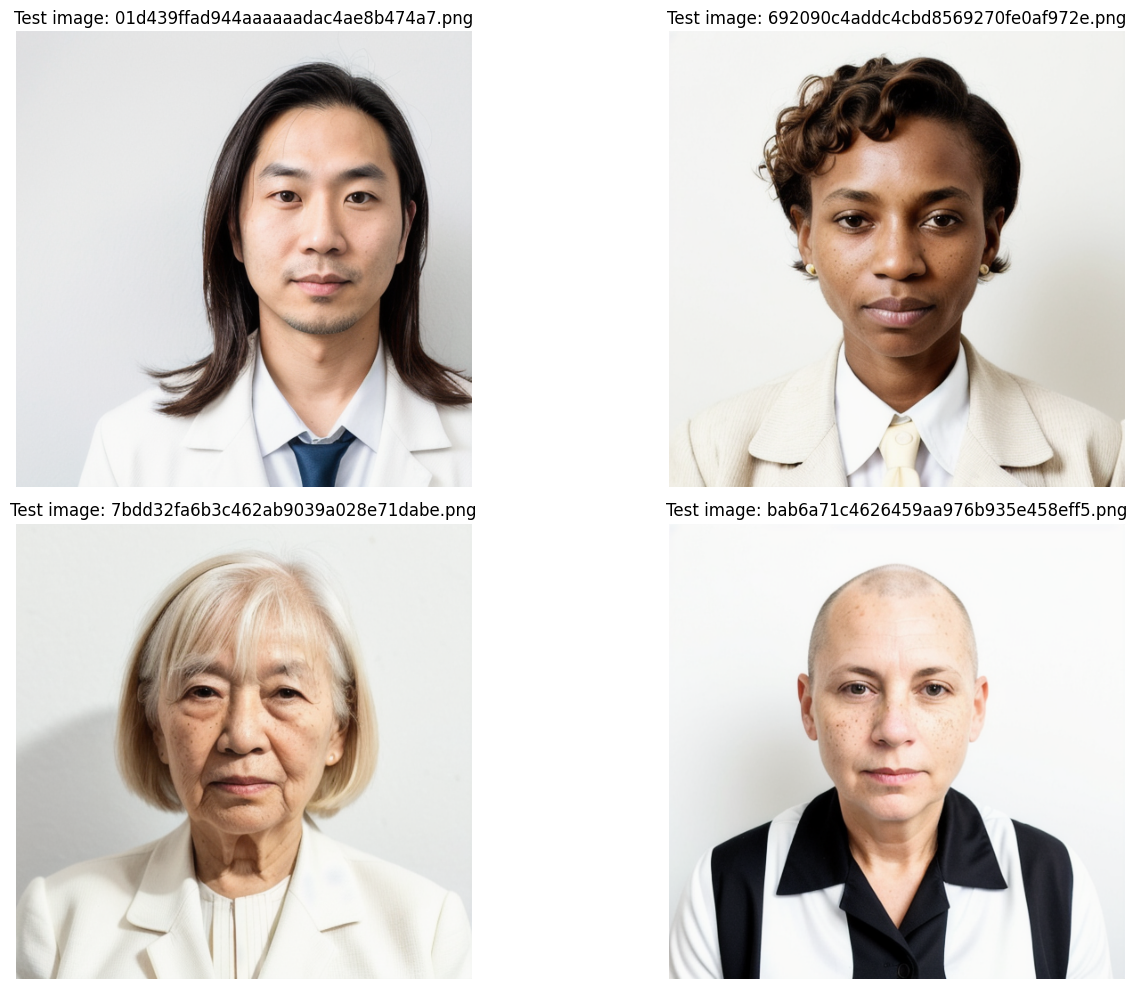

In [ ]:
# Let's look at some sample images
def show_examples(df, base_dir, num_examples=3):
    plt.figure(figsize=(15, 5*num_examples))

    # Show examples of compliant images
    if 'label' in df.columns:
        compliant_samples = df[df['label'] == 1].sample(num_examples)
        non_compliant_samples = df[df['label'] == 0].sample(num_examples)

        for i, (_, row) in enumerate(compliant_samples.iterrows()):
            plt.subplot(num_examples, 2, i*2+1)
            img_path = os.path.join(base_dir, row['path'])
            img = Image.open(img_path)
            plt.imshow(img)
            plt.title(f"Compliant (Label: {row['label']})")
            plt.axis('off')

        for i, (_, row) in enumerate(non_compliant_samples.iterrows()):
            plt.subplot(num_examples, 2, i*2+2)
            img_path = os.path.join(base_dir, row['path'])
            img = Image.open(img_path)
            plt.imshow(img)
            plt.title(f"Non-compliant (Label: {row['label']})")
            plt.axis('off')
    else:
        # For test set without labels
        samples = df.sample(num_examples*2)
        for i, (_, row) in enumerate(samples.iterrows()):
            plt.subplot(num_examples, 2, i+1)
            img_path = os.path.join(base_dir, row['path'])
            img = Image.open(img_path)
            plt.imshow(img)
            plt.title(f"Test image: {os.path.basename(row['path'])}")
            plt.axis('off')

    plt.tight_layout()
    plt.show()

# Display sample images
try:
    print("Sample training images:")
    show_examples(train_df, BASE_DIR + '/train', num_examples=3)

    print("Sample test images:")
    show_examples(test_df, BASE_DIR + '/test', num_examples=2)
except Exception as e:
    print(f"Error displaying images: {e}")

## Dataset and Augmentations

In [ ]:
# Dataloader class for ICAO compliance images
class ICACDataset(Dataset):
    def __init__(self, dataframe, base_dir, transform=None, test=False):
        self.dataframe = dataframe
        self.base_dir = base_dir
        self.transform = transform
        self.test = test  # Flag for test dataset (no labels)

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]

        # Construct image path based on train/val/test split, including the extra folder level
        if self.test:  # For test set
            img_path = os.path.join(self.base_dir, 'test', row['path'])  # Add 'test' for subfolder
        elif 'val' in row['path']:  # For validation set
            img_path = os.path.join(self.base_dir, 'val', row['path'])  # Add 'val' for subfolder
        else:  # For train set
            img_path = os.path.join(self.base_dir, 'train', row['path'])  # Add 'train' for subfolder

        # Load image
        try:
            img = Image.open(img_path).convert('RGB')  # Convert to RGB to handle grayscale images
            img = np.array(img)  # Convert to numpy array for albumentations

            # Apply transformations
            if self.transform:
                transformed = self.transform(image=img)
                img = transformed["image"]

            # For test dataset, return image and path
            if self.test or 'label' not in self.dataframe.columns:
                return img, row['path']

            # For train/val dataset, return image and label
            return img, torch.tensor(row['label'], dtype=torch.float32)

        except Exception as e:
            print(f"Error loading {img_path}: {e}")
            # Return a black image as fallback
            img = np.zeros((IMG_SIZE, IMG_SIZE, 3), dtype=np.uint8)
            if self.transform:
                transformed = self.transform(image=img)
                img = transformed["image"]

            if self.test or 'label' not in self.dataframe.columns:
                return img, row['path']
            return img, torch.tensor(row.get('label', 0), dtype=torch.float32)

In [ ]:
# Define strong augmentations for training
train_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(p=0.5, shift_limit=0.05, scale_limit=0.1, rotate_limit=15),
    A.RandomBrightnessContrast(p=0.5, brightness_limit=0.15, contrast_limit=0.15),
    A.GaussNoise(p=0.3, var_limit=(10, 50)),
    A.GaussianBlur(p=0.2, blur_limit=(3, 5)),
    A.CLAHE(p=0.3, clip_limit=4.0),
    A.CoarseDropout(p=0.3, max_holes=8, max_height=int(IMG_SIZE*0.1), max_width=int(IMG_SIZE*0.1)),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

# No augmentation for validation and test
val_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

# Create datasets
train_dataset = ICACDataset(train_df, BASE_DIR, transform=train_transform)
val_dataset = ICACDataset(val_df, BASE_DIR, transform=val_transform)
test_dataset = ICACDataset(test_df, BASE_DIR, transform=val_transform, test=True)

# Create weighted sampler for handling class imbalance
def get_weighted_sampler(dataframe):
    class_counts = dataframe['label'].value_counts().to_dict()
    weights = [1.0 / class_counts[label] for label in dataframe['label'].values]
    sampler = torch.utils.data.WeightedRandomSampler(weights, len(weights), replacement=True)
    return sampler

# Create weighted sampler
if 'label' in train_df.columns:
    train_sampler = get_weighted_sampler(train_df)
else:
    train_sampler = None

# Create data loaders
train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE,
    sampler=train_sampler, num_workers=NUM_WORKERS,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset, batch_size=BATCH_SIZE,
    shuffle=False, num_workers=NUM_WORKERS,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE,
    shuffle=False, num_workers=NUM_WORKERS,
    pin_memory=True
)

print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

Training batches: 63
Validation batches: 14
Test batches: 14


## Model Definition

In [ ]:
# Creating a custom classifier head for our use case - this is our innovative approach
# Model definition using timm for better models 
class ICACModel(nn.Module):
    def __init__(self, model_name=MODEL_NAME, pretrained=True):
        super(ICACModel, self).__init__()
        # Load a pretrained model
        self.backbone = timm.create_model(model_name, pretrained=pretrained)

        # Get the number of features in the last layer
        if hasattr(self.backbone, 'classifier'):
            n_features = self.backbone.classifier.in_features
            self.backbone.classifier = nn.Identity()
        elif hasattr(self.backbone, 'fc'):
            n_features = self.backbone.fc.in_features
            self.backbone.fc = nn.Identity()
        elif hasattr(self.backbone, 'head'):
            n_features = self.backbone.head.in_features
            self.backbone.head = nn.Identity()
        else:
            raise ValueError(f"Could not find classifier layer in model {model_name}")

        # Custom classifier head
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(n_features, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        # Extract features
        x = self.backbone(x)
        # Pass through classifier head
        x = self.classifier(x)
        return x.squeeze()  # Reshape from [batch, 1] to [batch]

# Initialize model
try:
    model = ICACModel(model_name=MODEL_NAME, pretrained=True).to(device)
    print(f"Model initialized: {MODEL_NAME}")

    # Get model parameter count
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,} ({trainable_params/total_params*100:.2f}%)")
except Exception as e:
    print(f"Error initializing model: {e}")

## Training Functions

In [ ]:
# Function to find optimal threshold for F1 score
def find_optimal_threshold(outputs, labels):
    best_f1 = 0
    best_threshold = 0.5

    # Convert outputs to probabilities
    probs = torch.sigmoid(torch.tensor(outputs)).numpy()

    # Try different thresholds to maximize F1
    thresholds = np.linspace(0.05, 0.95, 100)
    for threshold in thresholds:
        preds = (probs >= threshold).astype(int)
        f1 = f1_score(labels, preds)

        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold

    return best_threshold, best_f1

# Training function for one epoch with mixed precision
def train_epoch(model, dataloader, criterion, optimizer, scaler, device, mixed_precision=True):
    model.train()
    train_loss = 0
    all_preds = []
    all_labels = []
    all_outputs = []

    # Progress bar
    pbar = tqdm(dataloader, desc="Training")

    for images, labels in pbar:
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass with mixed precision
        if mixed_precision:
            # Remove 'device_type='cuda'' to use default behavior
            with autocast(): # This assumes you want to use the default device for autocast
                outputs = model(images)
                loss = criterion(outputs, labels)

            # Backward pass with scaling
            optimizer.zero_grad()
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            # Standard forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Standard backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Track metrics
        train_loss += loss.item() * images.size(0)
        preds = torch.sigmoid(outputs) >= 0.5

        all_preds.extend(preds.detach().cpu().numpy())
        all_labels.extend(labels.detach().cpu().numpy())
        all_outputs.extend(outputs.detach().cpu().numpy())

        # Update progress bar
        if len(all_labels) > 0:  # Avoid division by zero
            current_f1 = f1_score(all_labels, all_preds)
            pbar.set_postfix({"loss": loss.item(), "F1": current_f1})

    # Calculate final metrics
    train_loss = train_loss / len(dataloader.dataset)
    f1 = f1_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, zero_division=0)
    recall = recall_score(all_labels, all_preds, zero_division=0)

    # Find optimal threshold
    threshold, f1_at_threshold = find_optimal_threshold(all_outputs, all_labels)

    return train_loss, f1, precision, recall, threshold, f1_at_threshold

# Validation function
def validate(model, dataloader, criterion, device, mixed_precision=True):
    model.eval()
    val_loss = 0
    all_preds = []
    all_labels = []
    all_outputs = []

    # Progress bar
    pbar = tqdm(dataloader, desc="Validation")

    with torch.no_grad():
        for images, labels in pbar:
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass with mixed precision
            if mixed_precision:
                with autocast():
                    outputs = model(images)
                    loss = criterion(outputs, labels)
            else:
                outputs = model(images)
                loss = criterion(outputs, labels)

            # Track metrics
            val_loss += loss.item() * images.size(0)
            preds = torch.sigmoid(outputs) >= 0.5

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_outputs.extend(outputs.cpu().numpy())

            # Update progress bar
            if len(all_labels) > 0:  # Avoid division by zero
                current_f1 = f1_score(all_labels, all_preds)
                pbar.set_postfix({"loss": loss.item(), "F1": current_f1})

    # Calculate final metrics
    val_loss = val_loss / len(dataloader.dataset)
    f1 = f1_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, zero_division=0)
    recall = recall_score(all_labels, all_preds, zero_division=0)

    # Find optimal threshold
    all_outputs = np.array(all_outputs)
    all_labels = np.array(all_labels)
    threshold, f1_at_threshold = find_optimal_threshold(all_outputs, all_labels)

    return val_loss, f1, precision, recall, all_outputs, all_labels, threshold, f1_at_threshold

## Training Loop

In [ ]:
# Define loss function with class weighting
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([class_weights[1]/class_weights[0]]).to(device))

# Define optimizer and scheduler
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# Use a one-cycle learning rate scheduler
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=LEARNING_RATE,
    steps_per_epoch=len(train_loader),
    epochs=NUM_EPOCHS
)

# Training loop
best_val_f1 = 0
best_threshold = 0.5
history = {
    'train_loss': [], 'train_f1': [], 'train_threshold': [],
    'val_loss': [], 'val_f1': [], 'val_threshold': [],
    'val_precision': [], 'val_recall': []
}

# Start training
start_time = time.time()
for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")

    # Train
    train_loss, train_f1, train_precision, train_recall, train_threshold, train_f1_at_threshold = train_epoch(
        model, train_loader, criterion, optimizer, scaler, device, mixed_precision=MIXED_PRECISION
    )

    # Validate
    val_loss, val_f1, val_precision, val_recall, val_outputs, val_labels, val_threshold, val_f1_at_threshold = validate(
        model, val_loader, criterion, device, mixed_precision=MIXED_PRECISION
    )

    # Update best model if validation F1 improves
    if val_f1_at_threshold > best_val_f1:
        best_val_f1 = val_f1_at_threshold
        best_threshold = val_threshold

        # Save model checkpoint
        model_path = os.path.join(OUTPUT_DIR, f"best_model_epoch{epoch+1}_f1{val_f1_at_threshold:.4f}.pt")
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'threshold': best_threshold,
            'val_f1': best_val_f1
        }, model_path)

        print(f"\nNew best model saved with F1: {best_val_f1:.4f} at threshold: {best_threshold:.4f}")

    # Record metrics
    history['train_loss'].append(train_loss)
    history['train_f1'].append(train_f1)
    history['train_threshold'].append(train_threshold)
    history['val_loss'].append(val_loss)
    history['val_f1'].append(val_f1)
    history['val_threshold'].append(val_threshold)
    history['val_precision'].append(val_precision)
    history['val_recall'].append(val_recall)

    # Print metrics
    print(f"\nTrain Loss: {train_loss:.4f}, Train F1: {train_f1:.4f}, Optimal threshold: {train_threshold:.4f}, F1 at threshold: {train_f1_at_threshold:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val F1: {val_f1:.4f}, Optimal threshold: {val_threshold:.4f}, F1 at threshold: {val_f1_at_threshold:.4f}")
    print(f"Val Precision: {val_precision:.4f}, Val Recall: {val_recall:.4f}")

    # Print classification report every epoch
    val_probs = torch.sigmoid(torch.tensor(val_outputs)).numpy()
    val_preds_at_threshold = (val_probs >= val_threshold).astype(int)
    report = classification_report(val_labels, val_preds_at_threshold, target_names=["Non-compliant", "Compliant"])
    print(f"\nClassification Report (threshold={val_threshold:.4f}):")
    print(report)

    # Plot confusion matrix every epoch
    cm = confusion_matrix(val_labels, val_preds_at_threshold)

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, cmap='Blues')
    plt.title(f'Confusion Matrix - Epoch {epoch+1}')
    plt.colorbar()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    classes = ['Non-Compliant', 'Compliant']
    plt.xticks([0, 1], classes)
    plt.yticks([0, 1], classes)

    # Add values to cells
    thresh = cm.max() / 2
    for i in range(len(classes)):
        for j in range(len(classes)):
            plt.text(j, i, cm[i, j], ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.show()

    # Clean up to avoid CUDA memory issues
    gc.collect()
    torch.cuda.empty_cache()

# Training time
training_time = time.time() - start_time
print(f"\nTotal training time: {training_time/60:.2f} minutes")

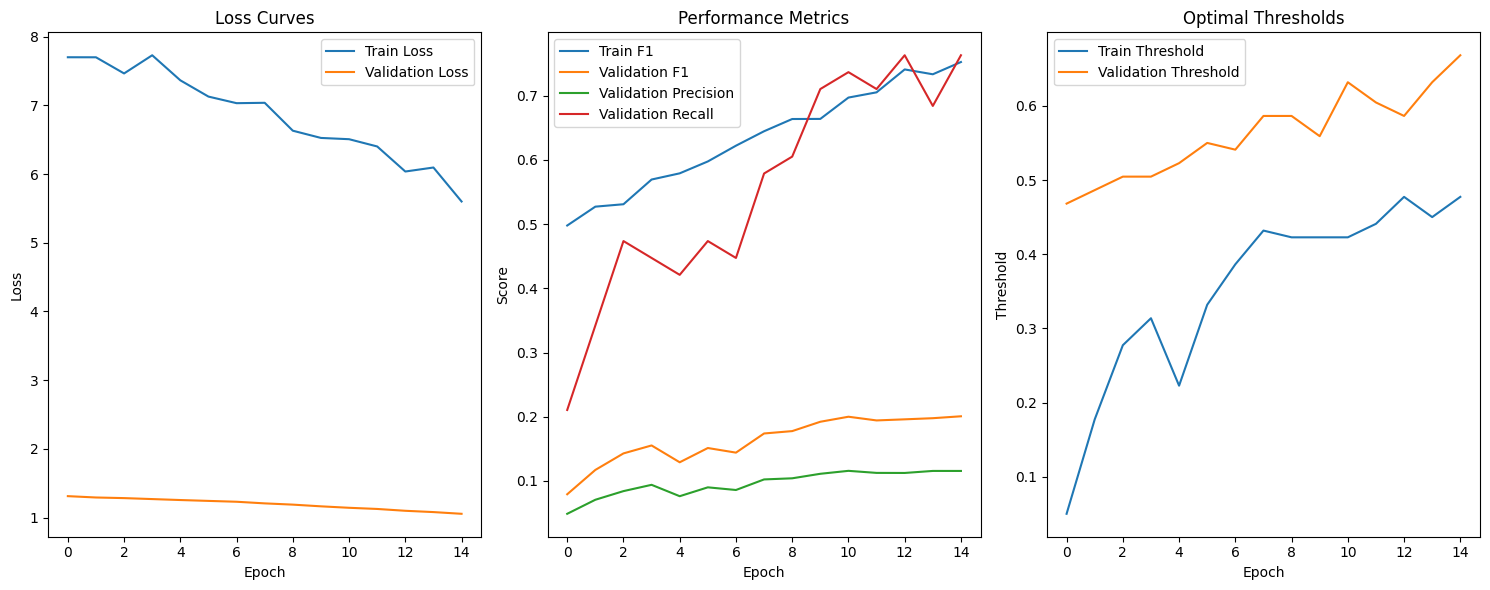

In [ ]:
# Plot training history
plt.figure(figsize=(15, 6))

# Loss plot
plt.subplot(1, 3, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.legend()

# F1 score plot
plt.subplot(1, 3, 2)
plt.plot(history['train_f1'], label='Train F1')
plt.plot(history['val_f1'], label='Validation F1')
plt.plot(history['val_precision'], label='Validation Precision')
plt.plot(history['val_recall'], label='Validation Recall')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.title('Performance Metrics')
plt.legend()

# Threshold plot
plt.subplot(1, 3, 3)
plt.plot(history['train_threshold'], label='Train Threshold')
plt.plot(history['val_threshold'], label='Validation Threshold')
plt.xlabel('Epoch')
plt.ylabel('Threshold')
plt.title('Optimal Thresholds')
plt.legend()

plt.tight_layout()
plt.show()

## Generate Predictions for Test Set

In [ ]:
# Load best model for inference
def load_best_model():
    # Find the latest best model file
    model_files = [f for f in os.listdir(OUTPUT_DIR) if f.startswith('best_model_epoch') and f.endswith('.pt')]
    if not model_files:
        print("No saved model found. Using current model.")
        return model, best_threshold

    # Sort by F1 score in filename
    best_model_file = max(model_files, key=lambda x: float(x.split('f1')[1].split('.pt')[0]))

    # Load checkpoint with weights_only=False (proceed with caution if checkpoint is from an untrusted source)
    checkpoint = torch.load(os.path.join(OUTPUT_DIR, best_model_file), weights_only=False)

    # Load model state
    model.load_state_dict(checkpoint['model_state_dict'])
    threshold = checkpoint['threshold']
    best_f1 = checkpoint['val_f1']
    epoch = checkpoint['epoch']

    print(f"Loaded best model from epoch {epoch+1} with F1 score {best_f1:.4f}")
    print(f"Using threshold: {threshold:.4f}")

    return model, threshold

In [ ]:
# Load best model and get threshold
model, threshold = load_best_model()  # Call load_best_model to get threshold


# Generate predictions for test set
def generate_test_predictions(model, dataloader, threshold, device, mixed_precision=True):
    model.eval()
    predictions = []
    image_paths = []

    with torch.no_grad():
        for images, paths in tqdm(dataloader, desc="Generating predictions"):
            images = images.to(device)

            # Forward pass with mixed precision
            if mixed_precision:
                with autocast():
                    outputs = model(images)
            else:
                outputs = model(images)

            # Convert to probabilities and apply threshold
            probs = torch.sigmoid(outputs).cpu().numpy()
            preds = (probs >= threshold).astype(int)

            predictions.extend(preds)
            image_paths.extend(paths)

    return image_paths, predictions

# Generate predictions
image_paths, predictions = generate_test_predictions(model, test_loader, threshold, device, mixed_precision=MIXED_PRECISION)

# Create submission dataframe
submission_df = pd.DataFrame({
    'path': image_paths,
    'label': predictions
})

# Save submission file
submission_df.to_csv(OUTPUT_FILE, index=False)
print(f"Submission file created at {OUTPUT_FILE} with {len(submission_df)} predictions")
submission_df.head()

Loaded best model from epoch 15 with F1 score 0.3011
Using threshold: 0.6682


Generating predictions:   0%|          | 0/14 [00:00<?, ?it/s]

<ipython-input-74-bed8258c4605>:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Submission file created at ./submission.csv with 853 predictions


path  label
0  test/7ec8b90644fa446ba599b4647d373e5a.png      0
1  test/0ebd68bd949946d2a1980ba492019fde.png      0
2  test/64e3460b8fb943f4afff5d5446d81cfb.png      0
3  test/7f9682989c40493680e4c9befb26f57c.png      0
4  test/548e2384daae4d55adad0215ec60fa8b.png      0

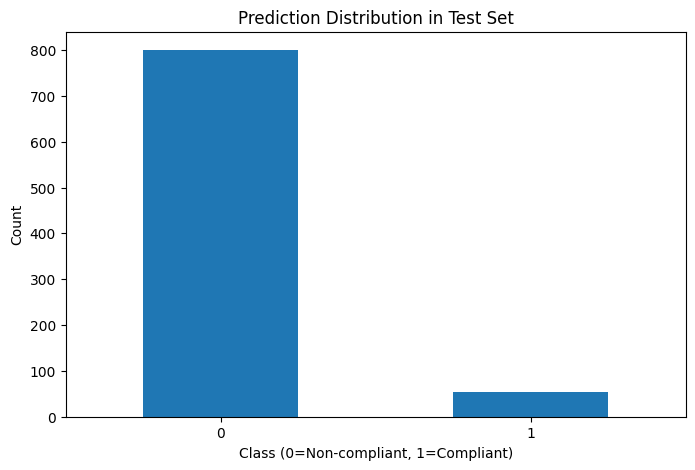

Prediction distribution:
label
0    800
1     53
Name: count, dtype: int64
Percentage compliant: 6.21%


In [ ]:
# Visualize prediction distribution
plt.figure(figsize=(8, 5))
submission_df['label'].value_counts().plot(kind='bar')
plt.title('Prediction Distribution in Test Set')
plt.xlabel('Class (0=Non-compliant, 1=Compliant)')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

# Print prediction statistics
print(f"Prediction distribution:\n{submission_df['label'].value_counts()}")
print(f"Percentage compliant: {100 * submission_df['label'].mean():.2f}%")